<a href="https://colab.research.google.com/github/ailunguo/Test/blob/main/Opencv_Test/image_processing_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

In [5]:
region_img = cv.imread('/content/drive/MyDrive/zhihui/cat_2.jpg')
img = region_img.copy()

# 形态转变

原图像
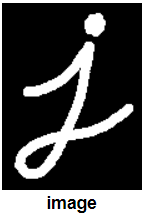

In [ ]:
# 侵蚀
# 原始图像中的一个像素（无论是1还是0）只有当核下的所有像素都为1时才会被认为是1，否则它会被侵蚀（变成0）
img = cv.imread('j.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(img,kernel,iterations = 1)

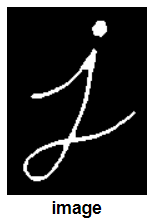

In [ ]:
# 膨胀
# 与膨胀相反，只要有一个像素是1，就全变为1
dilation = cv.dilate(img,kernel,iterations = 1)

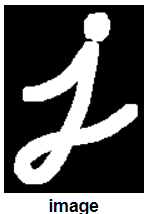

In [ ]:
# 开运算
opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

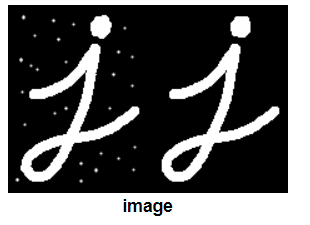

In [ ]:
# 闭运算
closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

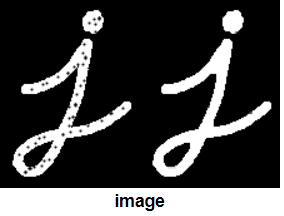

In [ ]:
# 形态梯度
gradient = cv.morphologyEx(img, cv.MORPH_GRADIENT, kernel)

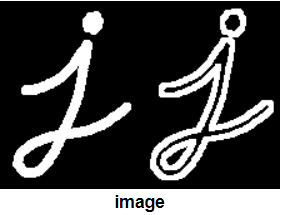

In [ ]:
# Top Hat
tophat = cv.morphologyEx(img, cv.MORPH_TOPHAT, kernel)

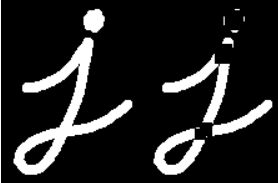

In [ ]:
# Black Hat
blackhat = cv.morphologyEx(img, cv.MORPH_BLACKHAT, kernel)

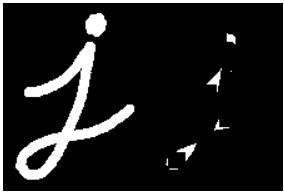

# 图像渐变

Sobel算子是联合高斯平滑加微分运算，因此抗噪声能力更强。您可以指定要取导数的方向，垂直或水平（分别通过参数 yorder 和 xorder）

通过参数ksize指定内核的大小

In [7]:
img_bgr = cv.cvtColor(img, cv.COLOR_RGB2BGR)

In [17]:
img_gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)
img_gray = cv.cvtColor(img_gray, cv.COLOR_RGB2BGR) # 灰度化后还要再转为BGR通道

In [8]:
import matplotlib.pyplot as plt

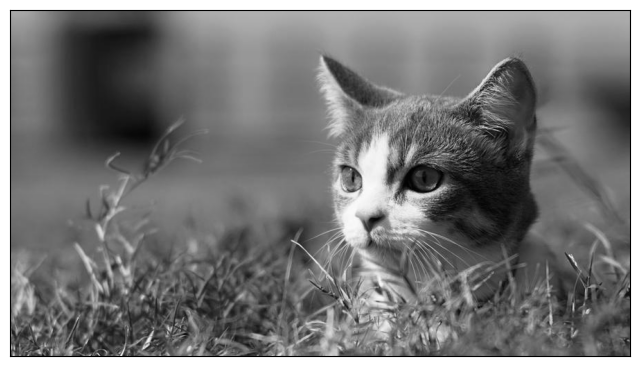

In [18]:
plt.figure(figsize=(8, 6))
plt.imshow(img_gray)
plt.xticks([]), plt.yticks([])
plt.show()

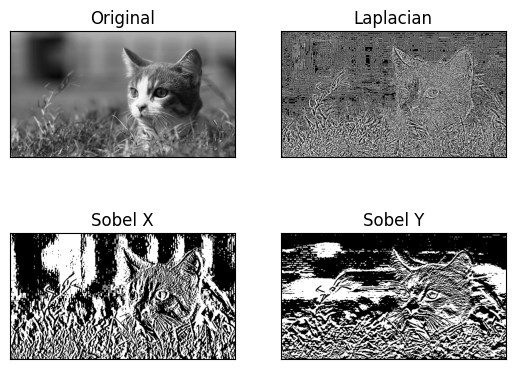

In [19]:
laplacian = cv.Laplacian(img_gray, cv.CV_64F)
sobelx = cv.Sobel(img_gray, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(img_gray, cv.CV_64F, 0, 1, ksize=5)

plt.subplot(2, 2, 1), plt.imshow(img_gray, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2, 2, 2), plt.imshow(laplacian, cmap='gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(2, 2, 3), plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(2, 2, 4), plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

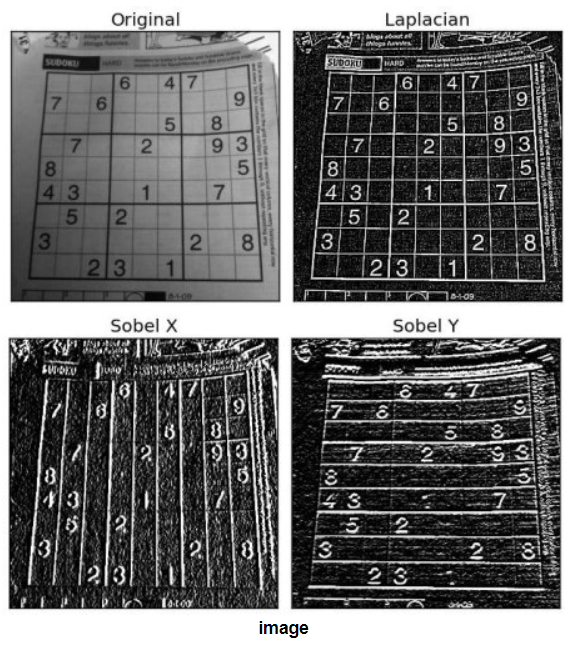

In [20]:
# 黑到白转换被视为正斜率（它具有正值），而白到黑转换被视为负斜率（它具有负值）。
# 因此，当您将数据转换为 np.uint8 时，所有负斜率均​​为零。简而言之，你会错过那个边缘。

In [21]:
# 水平方向的检测，将输出数据类型保留为更高的形式，取绝对值，然后转回cv.CV_8U

没加绝对值转8U会把原来是负值的给去掉，加绝对值再转8U就不会

In [ ]:
img = cv.imread('box.png', cv.IMREAD_GRAYSCALE)

# 处理输出得到cv.CV_8U类型
sobelx8u = cv.Sobel(img, cv.CV_8U, 1, 0, ksize=5)

# 输出cv.CV_64F类型，取绝对值转换为cv.CV_8U
sobelx64f = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)

plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx8u,cmap = 'gray')
plt.title('Sobel CV_8U'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobel_8u,cmap = 'gray')
plt.title('Sobel abs(CV_64F)'), plt.xticks([]), plt.yticks([])
plt.show()

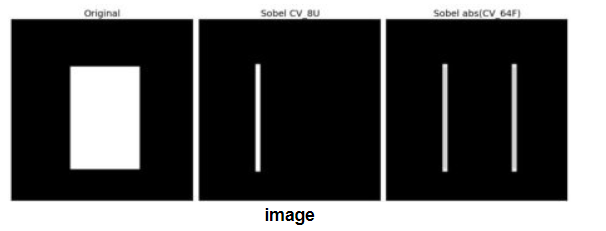

# Canny边缘检测

处理过程

1，降噪

由于边缘检测容易受到图像中噪声的影响，因此第一步是使用 5x5 高斯滤波器去除图像中的噪声

2，寻找图像的强度梯度

使用 Sobel 核在水平和垂直方向上对平滑后的图像进行滤波，以获得水平方向上的一阶导数（GX）和垂直方向（Gy）。从这两张图像中，我们可以找到每个像素的边缘梯度和方向，如下所示：

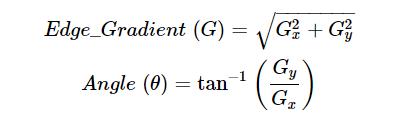

渐变方向始终垂直于边缘。它被舍入为代表垂直、水平和两个对角线方向的四个角度之一。

3，非最大值抑制

获得梯度大小和方向后，对图像进行全面扫描，以去除可能不构成边缘的任何不需要的像素。为此，在每个像素处，检查像素是否是其邻域中梯度方向的局部最大值。检查下图：

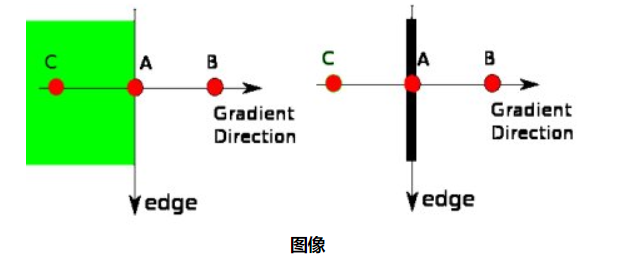

A点位于边缘（垂直方向）。渐变方向垂直于边缘。B 点和 C 点处于梯度方向。因此，将 A 点与 B 点和 C 点进行检查，看看它是否形成局部最大值。如果是，则考虑进入下一阶段，否则，将其抑制（置零）。

简而言之，您得到的结果是具有“薄边缘”的二值图像。

4，Hysteresis Thresholding迟滞阙值

此阶段决定哪些所有边都是真正的边，哪些不是。为此，我们需要两个阈值：minVal 和 maxVal。强度梯度大于 maxVal 的任何边缘都肯定是边缘，而低于 minVal 的边缘肯定是非边缘，因此被丢弃。位于这两个阈值之间的那些根据其连通性被分类为边缘或非边缘。如果它们连接到“确定边缘”像素，则它们被视为边缘的一部分。否则，它们也会被丢弃。见下图：

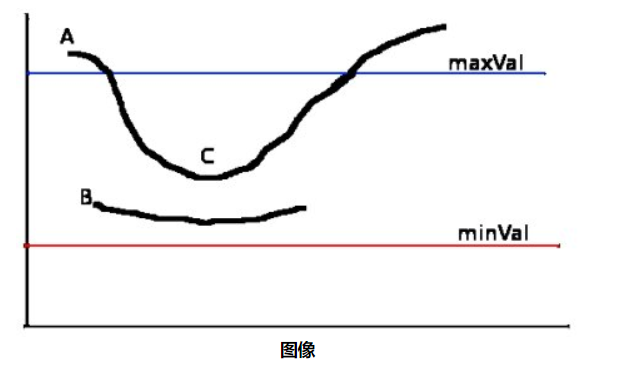

边缘 A 高于 maxVal，因此被视为“确定边缘”。虽然边 C 低于 maxVal，但它连接到边 A，因此也被视为有效边，我们得到了完整的曲线。但是边 B，虽然它在 minVal 之上并且与边 C 位于同一区域，但它没有连接到任何“sure-edge”，因此被丢弃。因此，我们必须相应地选择 minVal 和 maxVal 以获得正确的结果，这一点非常重要。

该阶段还假设边缘是长线，从而消除小像素噪声。


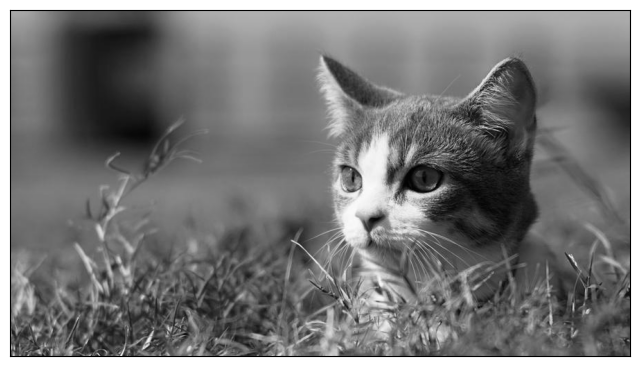

In [22]:
plt.figure(figsize=(8, 6))
plt.imshow(img_gray)
plt.xticks([]), plt.yticks([])
plt.show()

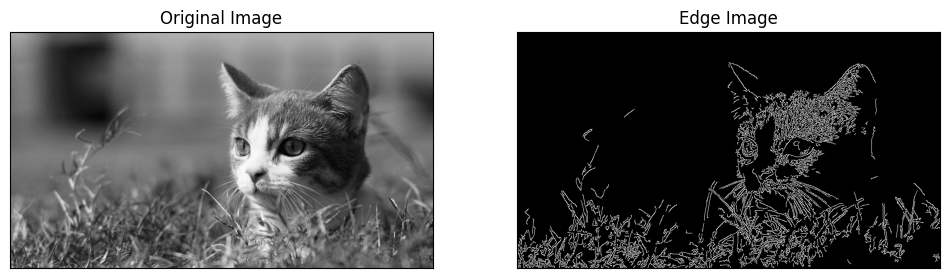

In [23]:
edges = cv.Canny(img_gray, 100, 200)

plt.figure(figsize=(12, 10))
plt.subplot(121), plt.imshow(img_gray, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()